In [499]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud, STOPWORDS
'''
from pycontractions import Contractions
cont = Contractions(api_key="glove-twitter-100")
'''
import contractions
from emot.emo_unicode import UNICODE_EMOJI # For emojis
from emot.emo_unicode import EMOTICONS_EMO # For EMOTICONS

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from scipy.sparse import csr_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import confusion_matrix, classification_report

from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prism\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\prism\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prism\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prism\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# NLP Project 2022

## Get data

In [413]:
url = 'https://raw.githubusercontent.com/SakibShahriar95/ANTiVax/main/Labeled/VaxMisinfoData.csv'
df = pd.read_csv(url)
df.head()

,id,is_misinfo
0,1344795424855642112,0
1,1344794858133860353,0
2,1344794822691983360,0
3,1344794752819077123,1
4,1344792070507134977,0


In [414]:
#  !pip install twarc
#  !twarc configure

Didn't work because of authentication

In [415]:
'''
from twarc import Twarc
from urllib.request import urlretrieve

tweet_ids_url = 'https://raw.githubusercontent.com/SakibShahriar95/ANTiVax/main/Labeled/ids.txt'
tweet_ids = urlretrieve(tweet_ids_url, './ids.txt') # it's a file like object and works just like a file

df = pd.read_csv('./ids.txt')
df.head()

consumer_key="2lNba8Nvu9f0i5YgfmQhfh3mP"
consumer_secret="TGVv9QJhtkjSqm7QyMeLfpZm3IU3xjrrMabyae42VxbkaT5t0g"
access_token="1600730532-ZCeeHr9h033QRlC95BLZrpz85TRFN4pZ0w7vGhY"
access_token_secret="eoiufziPLBr0eYgR12gAoAEiTQjlnTkZ1BHBLXoDuQbtC"
t = Twarc(consumer_key, consumer_secret, access_token, access_token_secret)

df = pd.DataFrame()
for tweet in t.hydrate(open('./ids.txt')):
  row = { 'id': tweet['id'], 'text': tweet['text'] }
  df.append(row, ignore_index = True)
'''


'\nfrom twarc import Twarc\nfrom urllib.request import urlretrieve\n\ntweet_ids_url = \'https://raw.githubusercontent.com/SakibShahriar95/ANTiVax/main/Labeled/ids.txt\'\ntweet_ids = urlretrieve(tweet_ids_url, \'./ids.txt\') # it\'s a file like object and works just like a file\n\ndf = pd.read_csv(\'./ids.txt\')\ndf.head()\n\nconsumer_key="2lNba8Nvu9f0i5YgfmQhfh3mP"\nconsumer_secret="TGVv9QJhtkjSqm7QyMeLfpZm3IU3xjrrMabyae42VxbkaT5t0g"\naccess_token="1600730532-ZCeeHr9h033QRlC95BLZrpz85TRFN4pZ0w7vGhY"\naccess_token_secret="eoiufziPLBr0eYgR12gAoAEiTQjlnTkZ1BHBLXoDuQbtC"\nt = Twarc(consumer_key, consumer_secret, access_token, access_token_secret)\n\ndf = pd.DataFrame()\nfor tweet in t.hydrate(open(\'./ids.txt\')):\n  row = { \'id\': tweet[\'id\'], \'text\': tweet[\'text\'] }\n  df.append(row, ignore_index = True)\n'

We hydrated offline and saved it to Github to retrieve it from there

In [416]:
url = 'https://raw.githubusercontent.com/krautgortna/NLP_Project_SS22/main/data/hydrated_tweets.csv'
all_data = pd.read_csv(url)
all_data.text

0        My 87 year old grandmother has been quarantini...
1        I’m so excited that with this vaccine I can se...
2        So excited that I was able to close out 2020 o...
3        Well, it happened. My daughter used my grandch...
4        I’m getting my COVID-19 vaccine, baby! I’m so ...
                               ...                        
12292    Ooh! Potential #CoronaVac by @Sinovac side-eff...
12293    This rocks, very excited to get the vaccine as...
12294    We're excited to announce a COVID-19 vaccinati...
12295    Dec 2020:\nMOH: Vaccines are here!\nFPs: Yay! ...
12296    Fauci to #unvaccinated Americans: “get over th...
Name: text, Length: 12297, dtype: object

In [417]:
Total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum() / all_data.isnull().count()).sort_values(ascending=False)
missing_stats = pd.concat([Total, percent], axis=1, keys=['Total', 'Percent'])

all_data_drop_80_missing = all_data.drop((missing_stats[missing_stats['Percent'] > .8]).index, axis=1)
missing_stats.head(25)

,Total,Percent
in_reply_to_status_id,12297,1.000000
retweet_screen_name,12297,1.000000
retweet_id,12297,1.000000
quote_id,12297,1.000000
in_reply_to_user_id,12297,1.000000
user_time_zone,12297,1.000000
in_reply_to_screen_name,12297,1.000000
coordinates,12265,0.997398
place,11785,0.958364
media,9704,0.789136


In [418]:
df_merged = df.merge(all_data[['id', 'text', 'hashtags']], on='id')
df_merged


,id,is_misinfo,text,hashtags
0,1344795424855642112,0,"if you kissed someone on Amelia St, don’t worr...",NaN
1,1344794858133860353,0,i really doubt 2021 will be much different imo...,NaN
2,1344794822691983360,0,"People want answers, but they’re also just exc...",NaN
3,1344794752819077123,1,Why any healthy person would want to take an e...,NaN
4,1344790296119422980,1,1/1 @TheBMA surely consenting people to a two ...,NaN
...,...,...,...,...
12292,1413088663886573569,1,"Go ahead, take it...#Vaccine #TheJab #Genocide...",Vaccine TheJab Genocide Depopulation Resist198...
12293,1413087751474397186,0,Going to my first vaccine today. Very very ner...,firstjab VACCINE hull hull2021
12294,1413087030578401283,0,"Media: ""The #Japanese government declared a ne...",Japanese coronavirus
12295,1413085519710363648,0,Getting my first dose vaccine tomorrow. HUKM d...,NaN


In [419]:
df_merged.drop_duplicates(subset='text')

,id,is_misinfo,text,hashtags
0,1344795424855642112,0,"if you kissed someone on Amelia St, don’t worr...",NaN
1,1344794858133860353,0,i really doubt 2021 will be much different imo...,NaN
2,1344794822691983360,0,"People want answers, but they’re also just exc...",NaN
3,1344794752819077123,1,Why any healthy person would want to take an e...,NaN
4,1344790296119422980,1,1/1 @TheBMA surely consenting people to a two ...,NaN
...,...,...,...,...
12292,1413088663886573569,1,"Go ahead, take it...#Vaccine #TheJab #Genocide...",Vaccine TheJab Genocide Depopulation Resist198...
12293,1413087751474397186,0,Going to my first vaccine today. Very very ner...,firstjab VACCINE hull hull2021
12294,1413087030578401283,0,"Media: ""The #Japanese government declared a ne...",Japanese coronavirus
12295,1413085519710363648,0,Getting my first dose vaccine tomorrow. HUKM d...,NaN


In [420]:
list(df_merged['hashtags'].str.split(" ").explode('hashtags').unique())

[nan,
 'HeroesOf2020',
 'MGH',
 'stopthespread',
 'lockdown',
 'StandStrong',
 'Covidvaccine',
 'CalltoArms',
 'BeGreatVaccinate',
 'ShotOfHope',
 '417fightscovid',
 'CovidVaccine',
 'GetVaccinated',
 'ThisIsOurShot',
 'Science',
 'scienceforthewin',
 'VaccinesWork',
 'COVID19',
 'WearAMask',
 'tweetiatrician',
 'HAPPYNEWYEAR2021',
 'GoodBye2020',
 'HAPPYNEWYEAR',
 'Newsmax',
 'VACCINE',
 'StopTheSpread',
 'covidvaccine',
 'COVID19vaccine',
 'getvaccinated',
 'sciencebitch',
 'igottheshot',
 'covid',
 'Idaho',
 'NewYearsEve',
 'ThisisOURshot',
 'CommunityImmunity',
 'carenotcovid',
 'BecauseTheJourneyMatters',
 'Moderna',
 'IDtwitter',
 'covidsucks',
 'bringin2021',
 'NotThrowingAwayMyShot',
 'COVID19Vaccine',
 'AMA',
 'OhioStateMedical',
 'vaccine',
 'Ouchie4Fauci',
 'PVTU',
 'DepopulationControl',
 'NWOplan',
 'GeorgiaGuidestones',
 'MedTwitter',
 'novaccine',
 'EndTheLockdowns',
 'GreatReset',
 'CovidFraud',
 'Throwback',
 'H1N1',
 'H1N1Vaccine',
 'Vaccine',
 'Covid',
 'Covid19',
 '

# EDA

In [421]:
# Who have the most tweets & how many are misinfo?
tweet_count = df.merge(all_data[['id', 'text', 'user_screen_name']], on='id')
tweet_count['count'] = tweet_count.groupby('user_screen_name')['user_screen_name'].transform('count')
tweet_count['total_misinfo'] = tweet_count.groupby('user_screen_name')['is_misinfo'].transform('sum')
tweet_count = tweet_count[['user_screen_name', 'count', 'total_misinfo']].drop_duplicates()
#tweet_count.loc[tweet_count['count'] > 1]
tweet_count.nlargest(50, 'count')

,user_screen_name,count,total_misinfo
281,robertbtracy,71,71
438,BrasscheckTV,13,13
512,KenMcCarthy,13,13
8132,saskvaccine,13,0
1128,citizenzee3,12,12
4467,CovidVaxster,12,0
6295,edendomain,12,12
189,DigbyKale,11,11
3423,jjoyce_r,11,11
4792,ScienceCareers,8,8


In [422]:
df.merge(all_data.loc[all_data['user_screen_name'] == 'KenMcCarthy'][['id', 'text', 'hashtags']], on='id')

,id,is_misinfo,text,hashtags
0,1344079779717373956,1,MDs who've issued public warnings re: the expe...,NaN
1,1344075466534170626,1,If you want to participate in the world's firs...,NaN
2,1343931287858524162,1,"Every time I see a post about ""the vaccine"", I...",NaN
3,1343682513911296001,1,Will post this every day. You might consider t...,NaN
4,1343006846060265472,1,Journalists and commentators: Let's clean up o...,NaN
5,1342517367251886081,1,"I wonder how many people realize that the ""vac...",NaN
6,1346235709938692099,1,How terribly inconvenient for the pharma con a...,NaN
7,1346107112749989888,1,"Everyone knows Fauci lies, but no one asks WHY...",NaN
8,1345858485251166211,1,2 issues: 1) Is compelled medical treatment of...,NaN
9,1345757691596189697,1,The reason behind the lies: How did a BS gene ...,NaN


[Text(0, 0, '8135 (66%)'), Text(0, 0, '4162 (34%)')]

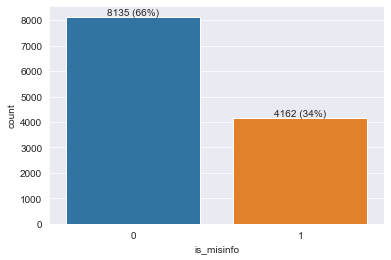

In [423]:
ax = sns.countplot(x=df_merged.is_misinfo)

abs_values = df_merged['is_misinfo'].value_counts(ascending=False)
rel_values = df_merged['is_misinfo'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)


In [424]:
print(df_merged.loc[df_merged['is_misinfo'] == 1].id.count())
print(df_merged.loc[df_merged['is_misinfo'] == 0].id.count())

4162
8135


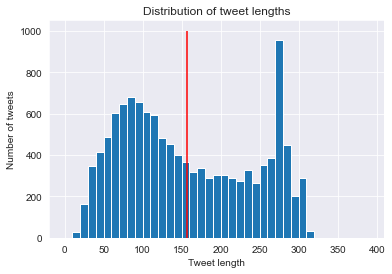

11
351


In [425]:
tweet_lengths = df_merged.text.apply(lambda x: len(x))
plt.hist(tweet_lengths, bins=range(0,400,10))
plt.xlabel('Tweet length')
plt.ylabel('Number of tweets')
plt.title('Distribution of tweet lengths')
plt.vlines(tweet_lengths.mean(), ymin=0, ymax=1000, colors='red')
plt.show()

print(tweet_lengths.min())
print(tweet_lengths.max())

In [426]:
# find all tweets containing emojis
emoji_tweets = pd.DataFrame(columns = ['tweetID', 'emoji', 'is_misinfo', 'tweet'])
for idx, tweet in enumerate(df_merged.text):
  for emot in UNICODE_EMOJI:
    if emot in tweet:
      emoji_tweets.loc[len(emoji_tweets.index)] = [df_merged['id'][idx], emot, df_merged.is_misinfo[idx], tweet]

emoji_tweets

,tweetID,emoji,is_misinfo,tweet
0,1344789441764737024,😂,0,so excited for The Vaccine that i got a tetanu...
1,1344789441764737024,🎉,0,so excited for The Vaccine that i got a tetanu...
2,1344782644408680448,🙈,0,I finally got an appointment for the COVID vac...
3,1344771024798285826,😅,0,Everyone saying “goodbye 2020” and acting exci...
4,1344770503014297602,🙏,1,"Well, it happened. My daughter used my grandch..."
...,...,...,...,...
4362,1413095225686331393,🤲🏻,0,"Alhamdulillah, vaccine day first dose💉🤲🏻 https..."
4363,1413095225686331393,💉,0,"Alhamdulillah, vaccine day first dose💉🤲🏻 https..."
4364,1413093526867378181,🥵,0,70% excited. 30% nervous for vaccine appointme...
4365,1413089672910213121,🥲,0,Got my second dose of the vaccine! Yay! But al...


In [427]:
emoji_misinfo_dist = emoji_tweets.groupby(['emoji', 'is_misinfo']).is_misinfo.count().nlargest(200).unstack()
emoji_misinfo_dist[0].nlargest(20)
#emoji_misinfo_dist.head(5).plot(kind='bar')


emoji
💉    360.0
🙏    145.0
❤    125.0
🏻    110.0
😭     87.0
🏼     80.0
🙌     79.0
😂     76.0
🥳     73.0
✅     69.0
🏽     63.0
💪     60.0
🥰     59.0
👍     58.0
🎉     53.0
😷     53.0
😊     51.0
😁     46.0
🥺     46.0
🏾     42.0
Name: 0, dtype: float64

In [428]:
emoji_misinfo_dist[1].nlargest(20)

emoji
🤔     49.0
💉     46.0
🙄     20.0
🤦     20.0
😂     19.0
♂     17.0
👇     16.0
🤣     15.0
🏾     14.0
♀     13.0
😡     12.0
🏻     11.0
🙏     11.0
🚨     11.0
🇺🇸    10.0
🤷     10.0
‼      8.0
🥴      8.0
☠      7.0
🏽      6.0
Name: 1, dtype: float64

### Are allcaps an indicator?

In [429]:
num_allcaps_words = pd.DataFrame(columns = ['id', 'num_allcaps_words', 'num_words', 'percent_allcaps_words', 'is_misinfo', 'tweet'])
for idx, tweet in enumerate(df_merged.text):
  tweet = tweet.replace("\n", " ")
  tweet = re.sub(r'[/\[\]\\\{\}\(\)\|\;\'\:\"\,\!\?\.]', '', tweet)
  words = tweet.split(" ")
  allcaps_count = 0.0
  for word in words:
    #len(word) > 2 because wods like 'I' aren't representative
    if len(word) > 2 and word.isupper():
      allcaps_count = allcaps_count + 1.0
  num_allcaps_words.loc[len(num_allcaps_words.index)] = [df_merged['id'][idx], allcaps_count, len(words), allcaps_count/len(words), df_merged.is_misinfo[idx], tweet]

num_allcaps_words.sort_values(by='num_allcaps_words', inplace=True)
num_allcaps_words

,id,num_allcaps_words,num_words,percent_allcaps_words,is_misinfo,tweet
0,1344795424855642112,0.0,14,0.000000,0,if you kissed someone on Amelia St don’t worry...
7263,1387836067404042246,0.0,36,0.000000,0,I received my second vaccine shot yesterday &a...
7266,1387835860888997891,0.0,32,0.000000,0,Vaccination Appointment 1st appt May 7 and 2n...
7268,1387835524166135808,0.0,12,0.000000,0,Only 75 people show up at South Bend vaccine c...
7269,1387835261300662273,0.0,15,0.000000,0,Why Not Take a Shot – #WhatAggravatesMe httpst...
...,...,...,...,...,...,...
3508,1360654515859574786,35.0,49,0.714286,1,CDC NEEDS TO ADMIT LABEL THE COVID VACCINE AS...
6391,1372354567438884867,35.0,48,0.729167,1,AND MARATHI MANOOS IS BORN WITH A SPECIAL BRAI...
8591,1385975111140925445,37.0,46,0.804348,1,CHINA AND BILL GATES AND YOUR ILLUMINATI GROUP...
3048,1346102824250314760,38.0,48,0.791667,1,ALL OF CONGRESS THE PRESIDENCY WILL BE EXEMPT ...


In [431]:
print(num_allcaps_words.groupby(['is_misinfo']).mean())

print("# all caps words: " + str(num_allcaps_words.num_allcaps_words.sum()))
print("# total words: " + str(num_allcaps_words.num_words.sum()))
print("% all caps words: " + str(num_allcaps_words.percent_allcaps_words.mean()))

                      id  num_allcaps_words  num_words  percent_allcaps_words
is_misinfo                                                                   
0           1.373930e+18           0.446466  22.602704               0.024570
1           1.373673e+18           1.429601  30.540125               0.052774
# all caps words: 9582.0
# total words: 310981
% all caps words: 0.034115868785390954


In [432]:
df_merged = df_merged.merge(num_allcaps_words[['id', 'num_allcaps_words']], on='id')
df_merged

,id,is_misinfo,text,hashtags,num_allcaps_words
0,1344795424855642112,0,"if you kissed someone on Amelia St, don’t worr...",NaN,0.0
1,1344794858133860353,0,i really doubt 2021 will be much different imo...,NaN,0.0
2,1344794822691983360,0,"People want answers, but they’re also just exc...",NaN,0.0
3,1344794752819077123,1,Why any healthy person would want to take an e...,NaN,0.0
4,1344790296119422980,1,1/1 @TheBMA surely consenting people to a two ...,NaN,0.0
...,...,...,...,...,...
12292,1413088663886573569,1,"Go ahead, take it...#Vaccine #TheJab #Genocide...",Vaccine TheJab Genocide Depopulation Resist198...,0.0
12293,1413087751474397186,0,Going to my first vaccine today. Very very ner...,firstjab VACCINE hull hull2021,1.0
12294,1413087030578401283,0,"Media: ""The #Japanese government declared a ne...",Japanese coronavirus,0.0
12295,1413085519710363648,0,Getting my first dose vaccine tomorrow. HUKM d...,NaN,1.0


### Wordcloud

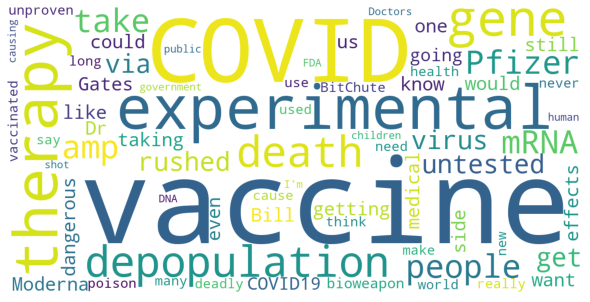

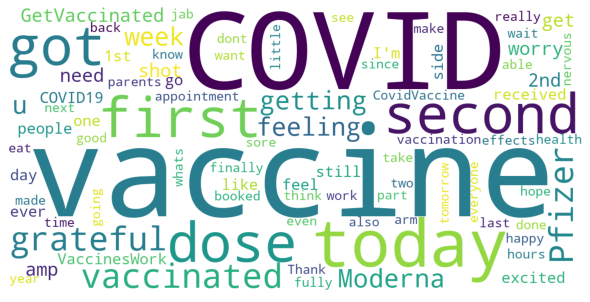

In [433]:
from collections import Counter

def plot_wordcloud(tweets, title):
  topwords = Counter(" ".join(tweets).split()).most_common(200)
  #print (topwords)
  topword_list = []
  for w, n in topwords:
      topword_list.append(w);

  topword_sentence = " ".join(topword_list) + " "
  #print(topword_sentence)

  stopwords = nltk.corpus.stopwords.words('english')
  wordcloud = WordCloud(width = 1200, height = 600,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(topword_sentence)

  # plot the WordCloud image
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

misinfo_texts = df_merged.text[df_merged['is_misinfo'] == 1]
plot_wordcloud(misinfo_texts, 'Top words for tweets classified as misinformation')
no_misinfo_texts = df_merged.text[df_merged['is_misinfo'] == 0]
plot_wordcloud(no_misinfo_texts, 'Top words for tweets classified as no-misinformation')


## Preprocessing

In [639]:
def remove_targets(review_text):
    return re.sub('(@[A-Za-z0-9])\w+', '', review_text)

def remove_hashtags(review_text):
    return review_text.replace("#", " ")

def remove_serial_post_pattern(review_text):
    return re.sub('[0-9]+\/[0-9]+', '', review_text)

def remove_numbers(review_text):
    return re.sub('[0-9]', '', review_text)

def remove_punctuation(review_text):
    review_text = re.sub(r'%', ' percent ', review_text)
    return re.sub(r'[/\[\]\\\{\}\(\)\|\;\'\:\"\,\!\?\.]', '', review_text)

def remove_newlines(review_text):
    return review_text.replace("\n", " ")

def lemmatize(tokens):
    try:
        wnl = nltk.WordNetLemmatizer()
    except LookupError:
        nltk.download('wordnet')
        wnl = nltk.WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in tokens]

def expand_contractions(review_text):
    return contractions.fix(review_text)

def convert_emojis(text):
    for emot in UNICODE_EMOJI:
      text = text.replace(emot, " " + emot + " " )
      text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
      text = text.replace("_", " ")
    return text

def remove_urls(text):
    return re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-z]{2,4}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)', '', text)

def convert_currencies(text):
    if "$" in text:
      text = text.replace("$", " dollar ")
    if "€" in text:
      text = text.replace("€", " euro ")
    if "£" in text:
      text = text.replace("£", " pound ")
    return text

def remove_consecutive_chars(text):
    #while groups of 3 chars can be found, replace them with the single char
    while re.findall(r'([a-z])\1\1', text):
      text = re.sub(r'([a-z])\1\1', r'\1', text)

    return text

def clean_misc(text):
  text = text.replace("tomo", "tomorrow")
  text = text.replace("&amp", "and")
  text = text.replace("vacccine", "vaccine")
  text = text.replace("bcs", "because")
  text = text.replace("1st", "first")
  text = text.replace("2nd", "second")
  text = text.replace("3rd", "third")

  return text

def remove_stopwords(text):
   return [ token for token in text
               if token not in nltk.corpus.stopwords.words('english')]

df_cleaned = df_merged.copy(deep=True)

df_cleaned['text'] = df_cleaned['text'].apply(remove_targets)
df_cleaned['text'] = df_cleaned['text'].apply(remove_hashtags)
#df_cleaned['text'] = df_cleaned['text'].apply(convert_emojis)
df_cleaned['text'] = df_cleaned['text'].apply(remove_urls) #use before remove_punctuation
df_cleaned['text'] = df_cleaned['text'].apply(expand_contractions) #use before remove_punctuation
df_cleaned['text'] = df_cleaned['text'].apply(remove_serial_post_pattern) #use before remove_punctuation
df_cleaned['text'] = df_cleaned['text'].apply(convert_currencies) #use before remove_punctuation
df_cleaned['text'] = df_cleaned['text'].apply(clean_misc)

#df_cleaned['text'] = df_cleaned['text'].apply(remove_numbers)

df_cleaned['text'] = df_cleaned['text'].apply(remove_punctuation)
df_cleaned['text'] = df_cleaned['text'].apply(remove_newlines)

df_cleaned['text'] = df_cleaned['text'].str.encode('ascii', 'ignore').str.decode('ascii')
df_cleaned['text'] = df_cleaned['text'].str.lower()
df_cleaned['text'] = df_cleaned['text'].str.replace("  ", " ") #ensure single space characters
df_cleaned['text'] = df_cleaned['text'].str.strip() #strip space at start and end

df_cleaned['text'] = df_cleaned['text'].apply(remove_consecutive_chars)
df_cleaned['text'] = df_cleaned['text'].apply(nltk.tokenize.word_tokenize)
df_cleaned['text'] = df_cleaned['text'].apply(remove_stopwords)
df_cleaned['text'] = df_cleaned['text'].apply(lemmatize) #maybe would work better with POS


df_cleaned

,id,is_misinfo,text,hashtags,num_allcaps_words
0,1344795424855642112,0,"[kissed, someone, amelia, st, worry, vaccine]",NaN,0.0
1,1344794858133860353,0,"[really, doubt, 2021, much, different, going, ...",NaN,0.0
2,1344794822691983360,0,"[people, want, answer, also, excited, get, vac...",NaN,0.0
3,1344794752819077123,1,"[healthy, person, would, want, take, experimen...",NaN,0.0
4,1344790296119422980,1,"[surely, consenting, people, two, part, licens...",NaN,0.0
...,...,...,...,...,...
12292,1413088663886573569,1,"[go, ahead, take, vaccine, thejab, genocide, d...",Vaccine TheJab Genocide Depopulation Resist198...,0.0
12293,1413087751474397186,0,"[going, first, vaccine, today, nervous, also, ...",firstjab VACCINE hull hull2021,1.0
12294,1413087030578401283,0,"[medium, japanese, government, declared, new, ...",Japanese coronavirus,0.0
12295,1413085519710363648,0,"[getting, first, dose, vaccine, tomorrowrrow, ...",NaN,1.0


In [640]:
df_cleaned_lemmatized = df_cleaned.copy(deep=True)
df_cleaned_lemmatized

,id,is_misinfo,text,hashtags,num_allcaps_words
0,1344795424855642112,0,"[kissed, someone, amelia, st, worry, vaccine]",NaN,0.0
1,1344794858133860353,0,"[really, doubt, 2021, much, different, going, ...",NaN,0.0
2,1344794822691983360,0,"[people, want, answer, also, excited, get, vac...",NaN,0.0
3,1344794752819077123,1,"[healthy, person, would, want, take, experimen...",NaN,0.0
4,1344790296119422980,1,"[surely, consenting, people, two, part, licens...",NaN,0.0
...,...,...,...,...,...
12292,1413088663886573569,1,"[go, ahead, take, vaccine, thejab, genocide, d...",Vaccine TheJab Genocide Depopulation Resist198...,0.0
12293,1413087751474397186,0,"[going, first, vaccine, today, nervous, also, ...",firstjab VACCINE hull hull2021,1.0
12294,1413087030578401283,0,"[medium, japanese, government, declared, new, ...",Japanese coronavirus,0.0
12295,1413085519710363648,0,"[getting, first, dose, vaccine, tomorrowrrow, ...",NaN,1.0


In [641]:
vocab_size_total = set()
for lemmas in df_cleaned['text']:
    vocab_size_total = vocab_size_total.union(set(lemmas))
print(len(vocab_size_total))

17431


In [642]:
print(df_merged['text'][9])
df_cleaned['text'][9]

I finally got an appointment for the COVID vaccine at my work and I am literally SO EXCITED 🙈


['finally',
 'got',
 'appointment',
 'covid',
 'vaccine',
 'work',
 'literally',
 'excited']

## Train model

In [643]:
df_original = df.merge(all_data[['id', 'text']], on='id')
df_original

,id,is_misinfo,text
0,1344795424855642112,0,"if you kissed someone on Amelia St, don’t worr..."
1,1344794858133860353,0,i really doubt 2021 will be much different imo...
2,1344794822691983360,0,"People want answers, but they’re also just exc..."
3,1344794752819077123,1,Why any healthy person would want to take an e...
4,1344790296119422980,1,1/1 @TheBMA surely consenting people to a two ...
...,...,...,...
12292,1413088663886573569,1,"Go ahead, take it...#Vaccine #TheJab #Genocide..."
12293,1413087751474397186,0,Going to my first vaccine today. Very very ner...
12294,1413087030578401283,0,"Media: ""The #Japanese government declared a ne..."
12295,1413085519710363648,0,Getting my first dose vaccine tomorrow. HUKM d...


In [644]:
def conc(text):
    return ' '.join(text)


df_cleaned['text'] = df_cleaned_lemmatized['text'].apply(conc)
df_cleaned

,id,is_misinfo,text,hashtags,num_allcaps_words
0,1344795424855642112,0,kissed someone amelia st worry vaccine,NaN,0.0
1,1344794858133860353,0,really doubt 2021 much different going corona ...,NaN,0.0
2,1344794822691983360,0,people want answer also excited get vaccine so...,NaN,0.0
3,1344794752819077123,1,healthy person would want take experimental va...,NaN,0.0
4,1344790296119422980,1,surely consenting people two part licensed vac...,NaN,0.0
...,...,...,...,...,...
12292,1413088663886573569,1,go ahead take vaccine thejab genocide depopula...,Vaccine TheJab Genocide Depopulation Resist198...,0.0
12293,1413087751474397186,0,going first vaccine today nervous also hate ne...,firstjab VACCINE hull hull2021,1.0
12294,1413087030578401283,0,medium japanese government declared new state ...,Japanese coronavirus,0.0
12295,1413085519710363648,0,getting first dose vaccine tomorrowrrow hukm d...,NaN,1.0


In [645]:
USE_CLEANED = True

X = df_cleaned.drop('is_misinfo', axis=1) if USE_CLEANED else df_original.drop('is_misinfo', axis=1)
y = df_cleaned.is_misinfo if USE_CLEANED else df_original.is_misinfo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9837, 4), (9837,), (2460, 4), (2460,))

In [646]:
X_train_texts = X_train.text

def get_ngram_tf_idf(n, X_texts):
    vectorizer = CountVectorizer(ngram_range=(1, n))
    vectorizer.fit(X_train_texts)
    X_ngram = vectorizer.transform(X_texts)
    ngram_tf_idf_transformer = TfidfTransformer()
    ngram_tf_idf_transformer.fit(X_ngram)
    return ngram_tf_idf_transformer.transform(X_ngram), X_ngram


# Unigram Tf-Idf
X_train_unigram_tf_idf,X_train_unigram = get_ngram_tf_idf(1, X_train_texts)
# Bigram Tf-Idf
X_train_bigram_tf_idf,X_train_bigram = get_ngram_tf_idf(2, X_train_texts)

In [647]:
def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.8, stratify=y
    )
    print(f'{title}')
    valid_score_sum = 0
    for Classifier in [SGDClassifier, XGBClassifier, MultinomialNB, LogisticRegression]:
        clf = Classifier()
        clf.fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        valid_score = clf.score(X_valid, y_valid)
        valid_score_sum += valid_score
        print(f'{clf.__str__()[:clf.__str__().index("(")]}: Train score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}')
    return valid_score_sum/3


titles = ['Unigram Counts', 'Unigram Tf-Idf', 'Bigram Counts', 'Bigram Tf-Idf']
X_train_list = [X_train_unigram, X_train_unigram_tf_idf, X_train_bigram, X_train_bigram_tf_idf]
transformers = zip(X_train_list, titles)
valid_scores = []
for X_train, title in transformers:
    valid_scores.append(train_and_show_scores(X_train, y_train, title))
print('Best transformer:', titles[np.argmax(valid_scores)])

Unigram Counts
SGDClassifier: Train score: 1.0 ; Validation score: 0.98
XGBClassifier: Train score: 0.99 ; Validation score: 0.98
MultinomialNB: Train score: 0.98 ; Validation score: 0.97
LogisticRegression: Train score: 1.0 ; Validation score: 0.98
Unigram Tf-Idf
SGDClassifier: Train score: 1.0 ; Validation score: 0.97
XGBClassifier: Train score: 0.99 ; Validation score: 0.97
MultinomialNB: Train score: 0.97 ; Validation score: 0.96
LogisticRegression: Train score: 0.99 ; Validation score: 0.97
Bigram Counts
SGDClassifier: Train score: 1.0 ; Validation score: 0.98
XGBClassifier: Train score: 0.99 ; Validation score: 0.97
MultinomialNB: Train score: 0.99 ; Validation score: 0.96
LogisticRegression: Train score: 1.0 ; Validation score: 0.97
Bigram Tf-Idf
SGDClassifier: Train score: 1.0 ; Validation score: 0.98
XGBClassifier: Train score: 0.99 ; Validation score: 0.98
MultinomialNB: Train score: 0.99 ; Validation score: 0.94
LogisticRegression: Train score: 0.99 ; Validation score: 0.96


### Hyperparameter search

In [648]:
# Take best performing transformer
x_train_transformed = X_train_list[np.argmax(valid_scores)]
clf = SGDClassifier(class_weight='balanced')

distributions = dict(
    penalty=['l1', 'l2', 'elasticnet'],
    alpha=uniform(loc=1e-6, scale=1e-4),
    loss=['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    learning_rate=['optimal', 'invscaling', 'adaptive'],
    eta0=uniform(loc=1e-7, scale=1e-2)
)

random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=distributions,
    cv=5,
    n_iter=50,
    n_jobs = -1,
)
random_search_cv.fit(x_train_transformed, y_train)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')

Best params: {'alpha': 5.174441306751066e-05, 'eta0': 0.0022843226535535148, 'learning_rate': 'adaptive', 'loss': 'hinge', 'penalty': 'l1'}
Best score: 0.9797704812330279


### Test model based on best hyperparameters

In [649]:
sgd_classifier = random_search_cv.best_estimator_
sgd_classifier.fit(x_train_transformed, y_train)

# get test data
x_test_transformed_list = []
for n in range(1, 3):
    X_test_ngram_tf_idf,X_test_ngram = get_ngram_tf_idf(n, X_test.text)
    x_test_transformed_list.extend([X_test_ngram, X_test_ngram_tf_idf])
x_test_transformed = x_test_transformed_list[np.argmax(valid_scores)]

#test score
score = sgd_classifier.score(x_test_transformed, y_test)
print("Test score SGD: ", score)

Test score SGD:  0.9821138211382113


In [650]:
# try MultinomialNB

# Vectorize text reviews to numbers
vec = CountVectorizer(ngram_range=(1, 1))
x_train = vec.fit_transform(X_train_texts).toarray()
x_test = vec.transform(X_test.text).toarray()

model = MultinomialNB()
model.fit(x_train, y_train)
score = model.score(x_test, y_test)
print("Test score MultinomialNB: ", score)

Test score MultinomialNB:  0.9691056910569106


In [651]:
clf = XGBClassifier()
clf.fit(x_train_transformed, y_train)
score = clf.score(x_test_transformed, y_test)
print("Test score XGB: ", score)

Test score XGB:  0.9817073170731707


In [652]:
classifier = LogisticRegression()
classifier.fit(x_train_transformed, y_train)
score = classifier.score(x_test_transformed, y_test)

print("Accuracy:", score)

Accuracy: 0.9821138211382113


In [613]:
# how long is largest tweet?
df_cleaned_length = df_cleaned_lemmatized.copy(deep=True)
df_cleaned_length['length'] = df_cleaned_length['text'].apply(len)
v_size = df_cleaned_length.nlargest(1, 'length')['length'].iloc[0]
v_size

110

In [614]:
df_cleaned_length['text']

0            [kissed, someone, amelia, st, worry, vaccine]
1        [really, doubt, 2021, much, different, going, ...
2        [people, want, answer, also, excited, get, vac...
3        [healthy, person, would, want, take, experimen...
4        [surely, consenting, people, two, part, licens...
                               ...                        
12292    [go, ahead, take, vaccine, thejab, genocide, d...
12293    [going, first, vaccine, today, nervous, also, ...
12294    [medium, japanese, government, declared, new, ...
12295    [getting, first, dose, vaccine, tomorrowrrow, ...
12296    [happy, mom, got, first, dose, vaccine, appoin...
Name: text, Length: 12297, dtype: object

## Keras model

In [615]:
import gensim
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, LSTM, Embedding, Hashing, Input, Bidirectional
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score


In [616]:
voc_size = 17533
#onehot_repre = [Hashing(' '.join(tweet), voc_size, output_mode='one_hot') for tweet in df_cleaned['text']]
onehot_repre = [one_hot(' '.join(words), voc_size) for words in df_cleaned_lemmatized['text']]
onehot_repre[0]

[4173, 15283, 3236, 8851, 4528, 5994]

In [617]:
sent_length = v_size
embedded_docs = pad_sequences(onehot_repre, padding='pre', maxlen=sent_length)
print(embedded_docs[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0  4173 15283  3236  8851
  4528  5994]


In [618]:
embedding_vector_features = 40
model_keras = Sequential()
model_keras.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model_keras.add(LSTM(100))
model_keras.add(Dense(1, activation='sigmoid'))
model_keras.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_keras.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 110, 40)           701320    
                                                                 
 lstm_14 (LSTM)              (None, 100)               56400     
                                                                 
 dense_54 (Dense)            (None, 1)                 101       
                                                                 
Total params: 757,821
Trainable params: 757,821
Non-trainable params: 0
_________________________________________________________________
None


In [619]:
x_final = np.array(embedded_docs)
y_final = df_cleaned['is_misinfo']

In [620]:
X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.2, random_state=42)

In [621]:
history = model_keras.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)

Epoch 1/20
154/154 [==============================] - 13s 75ms/step - loss: 0.3138 - accuracy: 0.8595 - val_loss: 0.0990 - val_accuracy: 0.9695
Epoch 2/20
154/154 [==============================] - 12s 77ms/step - loss: 0.0612 - accuracy: 0.9808 - val_loss: 0.1063 - val_accuracy: 0.9650
Epoch 3/20
154/154 [==============================] - 11s 71ms/step - loss: 0.0302 - accuracy: 0.9915 - val_loss: 0.0776 - val_accuracy: 0.9793
Epoch 4/20
154/154 [==============================] - 10s 68ms/step - loss: 0.0129 - accuracy: 0.9966 - val_loss: 0.0912 - val_accuracy: 0.9760
Epoch 5/20
154/154 [==============================] - 11s 71ms/step - loss: 0.2930 - accuracy: 0.9507 - val_loss: 0.2299 - val_accuracy: 0.9012
Epoch 6/20
154/154 [==============================] - 11s 70ms/step - loss: 0.0386 - accuracy: 0.9904 - val_loss: 0.1197 - val_accuracy: 0.9703
Epoch 7/20
154/154 [==============================] - 11s 71ms/step - loss: 0.0091 - accuracy: 0.9981 - val_loss: 0.1131 - val_accuracy:

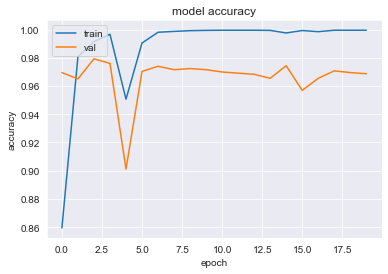

In [622]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

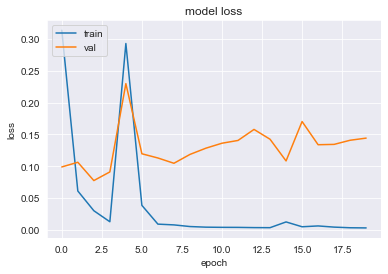

In [623]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [624]:
classes_x = (model_keras.predict(X_test) > 0.5).astype("int32")

77/77 [==============================] - 1s 11ms/step


In [638]:
from sklearn.model_selection import KFold

n = 5
kf = KFold(n_splits=n)
score = 0
f1 = 0
for train_idx, test_idx in kf.split(x_final, y_final):
    X_train, X_test, y_train, y_test = x_final[train_idx], x_final[test_idx], y_final.iloc[train_idx], y_final.iloc[test_idx]
    model_keras.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64, verbose=False)
    classes_x = (model_keras.predict(X_test) > 0.5).astype("int32")
    acc = accuracy_score(y_test,classes_x)
    print(acc)
    score += acc
    f1 += f1_score(y_test,classes_x)
print('LSTM:', score/n)
f1/n

77/77 [==============================] - 1s 12ms/step
0.9979674796747967
77/77 [==============================] - 1s 12ms/step
1.0
77/77 [==============================] - 1s 12ms/step
1.0
77/77 [==============================] - 1s 12ms/step
0.9995933306222041
77/77 [==============================] - 1s 12ms/step
0.9987799918666125
LSTM: 0.9992681604327227


0.9985790070546333

In [625]:
y_pred = model_keras.predict(X_test)
best_score = 0
activation = 0
for activa in range(10):
    score = accuracy_score(y_test,(y_pred > activa/10).astype("int32"))
    if score > best_score:
        best_score, activation = score, activa
print('Best score:', best_score, 'activation:', activation/10)

77/77 [==============================] - 1s 12ms/step
Best score: 0.9707317073170731 activation: 0.7


In [626]:
cf_matrix = confusion_matrix(y_test, classes_x)

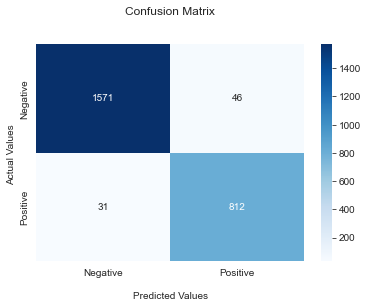

In [627]:
ax = sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [628]:
score_0 = accuracy_score(y_test,classes_x)
print(score_0)

0.96869918699187


77/77 [==============================] - 1s 7ms/step


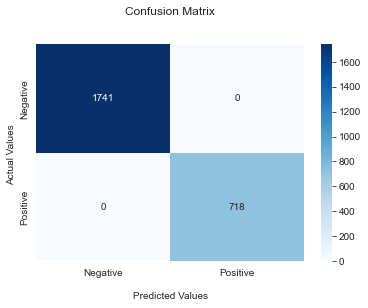

1.0

In [465]:
classes_x = (model_keras.predict(X_test) > activation/10).astype("int32")
cf_matrix = confusion_matrix(y_test, classes_x)
ax = sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])

## Display the visualization of the Confusion Matrix.
plt.show()
accuracy_score(y_test,classes_x)

## Num caps as additional input layer

77/77 [==============================] - 0s 616us/step
Best score: 0.6573170731707317 activation: 0.4


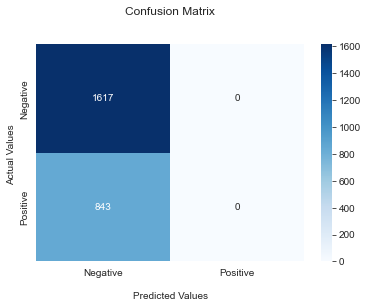

Accuracy: 0.6573170731707317


In [466]:
from keras.regularizers import l2
from keras.layers import concatenate
import tensorflow as tf

# Use Input layers, specify input shape (dimensions except first)
inp_cat_data = keras.layers.Input(shape=(sent_length,))
inp_num_data = keras.layers.Input(shape=(1,))
# Bind nulti_hot to embedding layer
emb = keras.layers.Embedding(input_dim=voc_size, output_dim=embedding_vector_features)(inp_cat_data)
# Also you need flatten embedded output of shape (?,3,2) to (?, 6) -
# otherwise it's not possible to concatenate it with inp_num_data
flatten = keras.layers.Flatten()(emb)
# Concatenate two layers
conc = keras.layers.Concatenate()([flatten, inp_num_data])
dense1 = keras.layers.Dense(3, activation=tf.nn.relu, )(conc)
# Creating output layer
out = keras.layers.Dense(1, activation=None)(dense1)
model = keras.Model(inputs=[inp_cat_data, inp_num_data], outputs=out)

model.compile(optimizer=keras.optimizers.Adam(0.01),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.mean_squared_error])

x_final = np.array(embedded_docs)
y_final = df_cleaned['is_misinfo']
X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.2, random_state=42)
model.fit([X_train, num_allcaps_words.iloc[y_train.index].num_allcaps_words], y_train)

y_pred = model.predict([X_test, num_allcaps_words.iloc[y_test.index].num_allcaps_words])
best_score = 0
activation = 0
for activa in range(10):
    score = accuracy_score(y_test,(y_pred > activa/10).astype("int32"))
    if score > best_score:
        best_score, activation = score, activa
print('Best score:', best_score, 'activation:', activation/10)

classes_x = (y_pred > 0.5).astype("int32")
cf_matrix = confusion_matrix(y_test, classes_x)
ax = sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')
ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

score_0 = accuracy_score(y_test,classes_x)
print('Accuracy:', score_0)

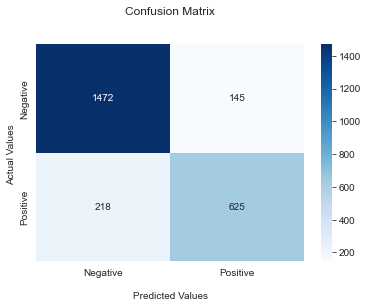

Accuracy: 0.8524390243902439


In [467]:
clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')
ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

score_0 = accuracy_score(y_test,y_pred)
print('Accuracy:', score_0)

In [468]:
# maybe if number of caps words ~ number of all words in tweet
df_merged_test = df_merged.copy(deep=True).iloc[y_test.index]
df_merged_test['is_misinfo_pred'] = classes_x
df_merged_test = df_merged_test.loc[~(df_merged_test['is_misinfo_pred'] == df_merged_test['is_misinfo'])]
print('Wrong predictions:', len(df_merged_test))
df_merged_test = df_merged_test.loc[df_merged_test['num_allcaps_words'] > 0]
print('Wrong predictions with #caps > 0:', len(df_merged_test))
df_merged_test

Wrong predictions: 843
Wrong predictions with #caps > 0: 368


,id,is_misinfo,text,hashtags,num_allcaps_words,is_misinfo_pred
9657,1389371591080005632,1,"Why are the Left, RINO's and elites hell-bent ...",Tucker TuckerCarlson,1.0,0
9573,1389593345186480134,1,Unmasked: Vaccinated People are making HEALTHY...,NaN,1.0,0
9677,1389321330613530629,1,Tucker Carlson will say Bill Gates was spendin...,NaN,1.0,0
10394,1404401124061425673,1,Hospital employees must get COVID vaccine or f...,NaN,1.0,0
6398,1372341231351570434,1,I REFUSE TO BE INJECTED WITH A EXPERIMENTAL GE...,NaN,11.0,0
...,...,...,...,...,...,...
4365,1359601121665429506,1,David Martin explains clearly what is required...,NaN,1.0,0
1785,1346904314053152768,1,Nurse in 'perfect health' found dead after get...,NaN,1.0,0
3529,1360574207948693505,1,People: the ‘vaccine’ is NOT A VACCINE. It is ...,NaN,11.0,0
6292,1372780548918190085,1,Depopulationist Pentagon pushing for kinetic w...,NaN,3.0,0
